
Overall Pearson r (pop vs. sightings): 0.83



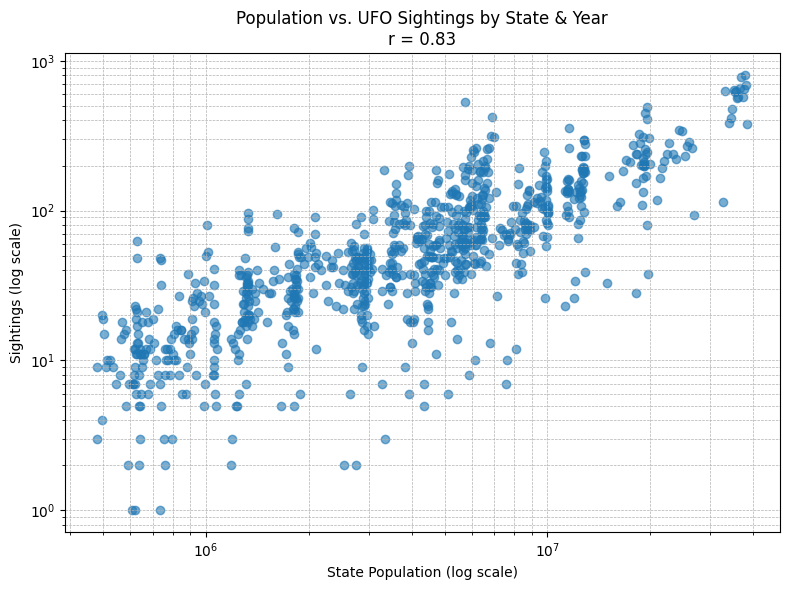

Yearly Pearson r’s:
 year  yearly_corr
 1998     0.752709
 1999     0.732413
 2000     0.815569
 2001     0.841439
 2002     0.894286
 2003     0.905307
 2004     0.905152
 2005     0.938772
 2006     0.929803
 2007     0.933623
 2008     0.960780
 2009     0.944613
 2010     0.915568
 2011     0.921191
 2012     0.900811
 2013     0.879849
 2014     0.827371


In [2]:
#!/usr/bin/env python3
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import pandas as pd
import matplotlib.pyplot as plt

def main():
    # ——— Reload filtered sightings ———
    ufo = pd.read_csv(
        'data/complete.csv',
        engine='python',
        sep=',',
        on_bad_lines='skip',
        dtype=str
    )
    ufo['state'] = ufo['state'].str.upper()
    ufo['date posted'] = pd.to_datetime(ufo['date posted'], errors='coerce')
    ufo = ufo.dropna(subset=['date posted'])
    ufo['year'] = ufo['date posted'].dt.year.astype(int)
    ufo_us = ufo[
        (ufo['country'].str.lower() == 'us') &
        (ufo['state'].isin(pd.read_csv('data/historical_state_population_by_year.csv')['state'].unique()))
    ]

    # ——— Aggregate sightings by (state, year) ———
    sightings = (
        ufo_us
        .groupby(['state', 'year'])
        .size()
        .reset_index(name='sightings')
        .astype({'sightings': int})
    )

    # ——— Load historical population ———
    pop = pd.read_csv(
        'data/historical_state_population_by_year.csv',
        dtype={'state': str, 'year': int, 'population': float}
    )

    # ——— Merge on state & year ———
    merged = pd.merge(
        sightings,
        pop,
        on=['state', 'year'],
        how='left'
    ).dropna(subset=['population'])

    # ——— Filter for positive values (needed for log scale) ———
    merged = merged[(merged['population'] > 0) & (merged['sightings'] > 0)]
    if merged.empty:
        print("No positive population/sighting pairs to analyze.")
        return

    # ——— Overall Pearson correlation ———
    overall_r = merged['population'].corr(merged['sightings'])
    print(f"\nOverall Pearson r (pop vs. sightings): {overall_r:.2f}\n")

    # ——— Log–log scatter plot ———
    plt.figure(figsize=(8,6))
    plt.scatter(merged['population'], merged['sightings'], alpha=0.6)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Population vs. UFO Sightings by State & Year\nr = {overall_r:.2f}')
    plt.xlabel('State Population (log scale)')
    plt.ylabel('Sightings (log scale)')
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # ——— Correlation by year ———
    corr_by_year = (
        merged
        .groupby('year')
        .apply(lambda df: df['population'].corr(df['sightings']) if len(df) > 1 else float('nan'))
        .reset_index(name='yearly_corr')
    )

    print("Yearly Pearson r’s:")
    print(corr_by_year.to_string(index=False))

if __name__ == '__main__':
    main()


In [3]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # limit BLAS threads to avoid errors

import pandas as pd

# Bokeh imports for interactive plotting
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool


def main():
    # ——— Load and preprocess UFO sightings ———
    ufo = pd.read_csv(
        'data/complete.csv',
        engine='python', sep=',', on_bad_lines='skip', dtype=str
    )
    ufo['state'] = ufo['state'].str.upper()
    ufo['date posted'] = pd.to_datetime(ufo['date posted'], errors='coerce')
    ufo = ufo.dropna(subset=['date posted'])
    ufo['year'] = ufo['date posted'].dt.year.astype(int)

    # Filter to US states present in population file
    pop_file = 'data/historical_state_population_by_year.csv'
    pop = pd.read_csv(pop_file, dtype={'state': str, 'year': int, 'population': float})
    valid_states = pop['state'].unique()
    ufo_us = ufo[(ufo['country'].str.lower() == 'us') & (ufo['state'].isin(valid_states))]

    # ——— Aggregate sightings by state & year ———
    sightings = (
        ufo_us
        .groupby(['state', 'year'])
        .size()
        .reset_index(name='sightings')
    )

    # ——— Merge with historical population ———
    merged = pd.merge(sightings, pop, on=['state', 'year'], how='left')
    merged = merged.dropna(subset=['population'])
    merged = merged[(merged['population'] > 0) & (merged['sightings'] > 0)]

    # ——— Compute overall Pearson correlation ———
    overall_r = merged['population'].corr(merged['sightings'])
    print(f"Overall Pearson r (population vs. sightings): {overall_r:.2f}")

    # ——— Prepare Bokeh interactive plot ———
    output_file("ufo_population_scatter.html", title="UFO Sightings vs Population")
    source = ColumnDataSource(merged)

    # Define tooltips to show only state and year (plus optional values)
    TOOLTIPS = [
        ("State", "@state"),
        ("Year", "@year"),
        # Uncomment below if you want population & sightings too
        # ("Population", "@population{0,0}"),
        # ("Sightings", "@sightings"),
    ]

    p = figure(
        title=f"Population vs. UFO Sightings by State & Year (r = {overall_r:.2f})",
        x_axis_type="log", y_axis_type="log",
        x_axis_label="State Population (log scale)",
        y_axis_label="Sightings (log scale)",
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )

    # Draw circles and attach hover tool specifically to them
    circles = p.circle(
        x='population', y='sightings', source=source,
        size=7, alpha=0.6
    )
    hover = HoverTool(renderers=[circles], tooltips=TOOLTIPS, mode='mouse')
    p.add_tools(hover)

    show(p)

    # ——— Yearly correlations ———
    corr_by_year = (
        merged
        .groupby('year')
        .apply(lambda df: df['population'].corr(df['sightings']) if len(df)>1 else float('nan'))
        .reset_index(name='yearly_corr')
    )
    print("\nYearly Pearson correlations (by year):")
    print(corr_by_year.to_string(index=False))


if __name__ == '__main__':
    main()


Overall Pearson r (population vs. sightings): 0.83



Yearly Pearson correlations (by year):
 year  yearly_corr
 1998     0.752709
 1999     0.732413
 2000     0.815569
 2001     0.841439
 2002     0.894286
 2003     0.905307
 2004     0.905152
 2005     0.938772
 2006     0.929803
 2007     0.933623
 2008     0.960780
 2009     0.944613
 2010     0.915568
 2011     0.921191
 2012     0.900811
 2013     0.879849
 2014     0.827371
